In [1]:
!pip install -q segmentation-models-pytorch==0.4.0 timm==1.0.3

In [3]:
! pip install albumentations

  Using cached opencv_python_headless-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (19 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached typing_inspection-0.4.2-py3-none-any.whl.metadata (2.6 kB)
Using cached opencv_python_headless-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (54.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.5 MB/s eta 0:00:00
Using cached annotated_types-0.7.0-py3-none-any.whl (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 651.2/651.2 kB 6.0 MB/s eta 0:00:00-:--:--
Using cached typing_extensions-4.15.0-py3-none-any.whl (44 kB)
Using cached typing_inspection-0.4.2-py3-none-any.whl (14 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typ

In [15]:
import os, time, numpy as np
from PIL import Image
from tqdm import tqdm
import torch, torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import timm
import segmentation_models_pytorch as smp

In [16]:
def patchify_image(img, mask, patch_size=512, overlap=128):
    patches = []
    step = patch_size - overlap
    H, W = img.shape[:2]
    for y in range(0, H - patch_size + 1, step):
        for x in range(0, W - patch_size + 1, step):
            img_patch = img[y:y+patch_size, x:x+patch_size]
            mask_patch = mask[y:y+patch_size, x:x+patch_size]
            patches.append((img_patch, mask_patch))
    return patches


class XBDDataset(Dataset):
    def __init__(self, root_dir, patch_size=512, overlap=128, transform=None, load_patches=True):
        self.img_dir = os.path.join(root_dir, "images")
        self.mask_dir = os.path.join(root_dir, "targets")
        self.patch_size = patch_size
        self.overlap = overlap
        self.transform = transform
        self.samples = []
        self.load_patches = load_patches  # False = lazy (for test)

        img_files = [f for f in os.listdir(self.img_dir) if f.endswith("_post_disaster.png")]
        print(f" Creating patch index from: {root_dir}")
        for f in tqdm(img_files):
            img_path = os.path.join(self.img_dir, f)
            mask_path = os.path.join(self.mask_dir, f.replace(".png", "_target.png"))
            if not os.path.exists(mask_path):
                continue
            img = np.array(Image.open(img_path))
            H, W = img.shape[:2]
            step = patch_size - overlap
            for y in range(0, H - patch_size + 1, step):
                for x in range(0, W - patch_size + 1, step):
                    self.samples.append((img_path, mask_path, x, y))
        print(f"Total patches indexed: {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path, x, y = self.samples[idx]
        img = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))
        img = img[y:y+self.patch_size, x:x+self.patch_size]
        mask = mask[y:y+self.patch_size, x:x+self.patch_size]
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img, mask = augmented["image"], augmented["mask"]
        return img, mask.long()

In [17]:
train_transforms = A.Compose([
    A.RandomRotate90(),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(0.2, 0.2),
    A.GaussNoise(var_limit=(10.0, 50.0)),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transforms = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

train_root = "train"
val_root = "hold"

train_dataset = XBDDataset(train_root, patch_size=256, overlap=64, transform=train_transforms)
val_dataset   = XBDDataset(val_root,   patch_size=256, overlap=64, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True,num_workers=4, pin_memory=True, persistent_workers=True)
val_loader   = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)

/tmp/ipykernel_4011826/4017448893.py:6: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0)),


 Creating patch index from: train


100%|██████████| 2799/2799 [01:13<00:00, 38.23it/s]


Total patches indexed: 69975
 Creating patch index from: hold


100%|██████████| 933/933 [00:24<00:00, 37.85it/s]


Total patches indexed: 23325


In [18]:
# ===================== Transformer Encoder + Segmentation Head =====================
NUM_CLASSES = 5

model = smp.Unet(
    encoder_name="mit_b2",          # SegFormer-B2 transformer encoder
    encoder_weights="imagenet",     # Pretrained on ImageNet
    in_channels=3,                  # RGB input
    classes=NUM_CLASSES,            # Number of segmentation classes
    activation=None                 # We'll use raw logits for CE + Dice loss
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f" Model initialized on {device}")

# Option 1: Freeze the entire Transformer encoder (train decoder only)
for name, param in model.encoder.named_parameters():
    param.requires_grad = False
print(" Encoder frozen — training decoder only.")

# Option 2 (optional): Unfreeze last two transformer blocks later
# for p in model.encoder.parameters():
#     p.requires_grad = False

# # Unfreeze last transformer block (B1 has blocks.0, blocks.1, blocks.2)
# for name, param in model.encoder.named_parameters():
#     if "blocks.2" in name:   # last block in MiT-B1
#         param.requires_grad = True

# print("Unfroze last transformer block of mit_b1.")

# ===================== Loss & Optimizer =====================
def dice_loss(pred, target, smooth=1e-6):
    pred = torch.softmax(pred, dim=1)
    target_onehot = F.one_hot(target, num_classes=pred.shape[1]).permute(0,3,1,2).float()
    inter = (pred * target_onehot).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + target_onehot.sum(dim=(2,3))
    dice = (2. * inter + smooth) / (union + smooth)
    return 1 - dice.mean()

def weighted_ce_loss(pred, target, weights):
    return F.cross_entropy(pred, target, weight=weights.to(pred.device))

def combined_loss(pred, target, weights, alpha=1.0, beta=0.5):
    ce, dc = weighted_ce_loss(pred, target, weights), dice_loss(pred, target)
    return alpha * ce + beta * dc

weights = torch.tensor([0.05, 1.0, 4.0, 6.0, 3.0])  
weights = weights / weights.sum() * len(weights)

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),lr=2e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

 Model initialized on cuda
 Encoder frozen — training decoder only.


In [19]:
from torch.amp import GradScaler, autocast
scaler = GradScaler(device="cuda")

def compute_iou(preds, targets, num_classes=5):
    preds = torch.argmax(preds, dim=1).cpu().numpy()
    targets = targets.cpu().numpy()
    ious = []
    for cls in range(num_classes):
        inter = np.logical_and(preds == cls, targets == cls).sum()
        union = np.logical_or(preds == cls, targets == cls).sum()
        ious.append(np.nan if union == 0 else inter / union)
    return ious

def compute_weighted_f1(preds, targets, num_classes=5):
    preds = torch.argmax(preds, dim=1).cpu().numpy().ravel()
    targets = targets.cpu().numpy().ravel()
    f1_per_class = f1_score(targets, preds, average=None, labels=list(range(num_classes)))
    support = np.array([(targets == i).sum() for i in range(num_classes)])
    weighted_f1 = np.sum(f1_per_class * support) / np.sum(support)
    return weighted_f1, f1_per_class

def train_one_epoch_amp(model, dataloader, optimizer, weights, scaler):
    model.train()
    run_loss = 0
    for imgs, masks in tqdm(dataloader, desc="Training", leave=False):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast(device_type="cuda"):
            out = model(imgs)
            loss = combined_loss(out, masks, weights)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        run_loss += loss.item()
    return run_loss / len(dataloader)

# def validate(model, dataloader, weights, max_batches=None):
#     model.eval()
#     val_loss, preds_all, targets_all = 0, [], []
#     with torch.no_grad():
#         for i, (imgs, masks) in enumerate(tqdm(dataloader, desc="Validating", leave=False)):
#             imgs, masks = imgs.to(device), masks.to(device)
#             with autocast(device_type="cuda"):
#                 out = model(imgs)
#                 loss = combined_loss(out, masks, weights)
#             val_loss += loss.item()
#             preds_all.append(out.cpu())
#             targets_all.append(masks.cpu())
#             if max_batches and i+1 >= max_batches: break
#     preds_all, targets_all = torch.cat(preds_all), torch.cat(targets_all)
#     wf1, f1s = compute_weighted_f1(preds_all, targets_all)
#     ious = compute_iou(preds_all, targets_all)
#     return {"val_loss": val_loss/len(dataloader), "weighted_f1": wf1, "f1_per_class": f1s, "iou": ious}
from sklearn.metrics import precision_recall_fscore_support

def update_confusion(confmat, preds_flat, targets_flat, num_classes):
    # preds_flat and targets_flat are 1D numpy arrays of same length
    # we compute bincount on pair ids: i = targets*num_classes + preds
    pairs = targets_flat.astype(np.int64) * num_classes + preds_flat.astype(np.int64)
    counts = np.bincount(pairs, minlength=num_classes*num_classes)
    confmat += counts.reshape((num_classes, num_classes))
    return confmat

def metrics_from_confusion(confmat):
    # confmat: rows = true, cols = pred
    tp = np.diag(confmat).astype(np.float64)
    support = confmat.sum(axis=1).astype(np.float64)           # true counts per class
    pred_sum = confmat.sum(axis=0).astype(np.float64)          # predicted counts per class

    # Precision = TP / predicted positives
    precision = np.divide(tp, pred_sum, out=np.zeros_like(tp), where=pred_sum>0)
    # Recall = TP / actual positives
    recall = np.divide(tp, support, out=np.zeros_like(tp), where=support>0)
    # F1
    f1 = np.divide(2 * precision * recall, precision + recall,
                   out=np.zeros_like(tp), where=(precision+recall)>0)

    # IoU = TP / (TP + FP + FN)  where FP = pred_sum - TP, FN = support - TP
    denom = tp + (pred_sum - tp) + (support - tp)
    iou = np.divide(tp, denom, out=np.zeros_like(tp), where=denom>0)

    # Weighted F1 (same as xBD): weight by support
    total_support = support.sum() if support.sum() > 0 else 1
    weighted_f1 = (f1 * support).sum() / total_support

    return {
        "precision": precision,
        "recall": recall,
        "f1_per_class": f1,
        "support": support,
        "iou_per_class": iou,
        "weighted_f1": weighted_f1
    }
    
def validate_efficient(model, dataloader, weights, num_classes=5, max_batches=None, device=device):
    model.eval()
    confmat = np.zeros((num_classes, num_classes), dtype=np.int64)
    val_loss = 0.0
    batches = 0

    with torch.no_grad():
        for i, (imgs, masks) in enumerate(tqdm(dataloader, desc="Validating", leave=False)):
            imgs, masks = imgs.to(device), masks.to(device)
            with autocast(device_type="cuda"):
                out = model(imgs)
                loss = combined_loss(out, masks, weights)
            val_loss += loss.item()
            # convert to preds (cpu numpy)
            preds = torch.argmax(out, dim=1).cpu().numpy().ravel()
            targets = masks.cpu().numpy().ravel()
            # optionally ignore pixels with label outside [0,num_classes-1]
            mask_valid = (targets >= 0) & (targets < num_classes)
            if mask_valid.sum() == 0:
                # no valid pixels in this batch
                batches += 1
                if max_batches and batches >= max_batches:
                    break
                continue
            preds = preds[mask_valid]
            targets = targets[mask_valid]
            # update confusion efficiently
            confmat = update_confusion(confmat, preds, targets, num_classes)
            batches += 1
            if max_batches and batches >= max_batches:
                break

    if batches == 0:
        return {"val_loss": np.nan, "weighted_f1": 0.0, "f1_per_class": np.zeros(num_classes), "iou": [np.nan]*num_classes}

    metrics = metrics_from_confusion(confmat)
    metrics["val_loss"] = val_loss / batches
    return metrics

In [20]:
# ===================== Training Loop =====================
import gc

NUM_EPOCHS = 25
best_f1, save_path = 0.0, "best_model.pth"

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    t0 = time.time()

    tr_loss = train_one_epoch_amp(model, train_loader, optimizer, weights, scaler)
    metrics = validate_efficient(model, val_loader, weights, num_classes=NUM_CLASSES, max_batches=100)
    scheduler.step()

    print(f"Train {tr_loss:.4f} | Val {metrics['val_loss']:.4f} | "
          f"Weighted F1 {metrics['weighted_f1']:.4f} | "
          f"Time {(time.time()-t0)/60:.1f} min")

    # save best
    if metrics["weighted_f1"] > best_f1:
        best_f1 = metrics["weighted_f1"]
        torch.save(model.state_dict(), save_path)
        print(f" Saved best model (Weighted F1 {best_f1:.4f})")

    # cleanup
    torch.cuda.empty_cache()
    gc.collect()


Epoch 1/25


Training:   0%|          | 0/34988 [00:00<?, ?it/s]

Train 1.2004 | Val 1.1800 | Weighted F1 0.8526 | Time 18.3 min
 Saved best model (Weighted F1 0.8526)

Epoch 2/25


Train 1.1059 | Val 1.1757 | Weighted F1 0.8557 | Time 18.3 min
 Saved best model (Weighted F1 0.8557)

Epoch 3/25


Train 1.0689 | Val 1.1441 | Weighted F1 0.8464 | Time 18.3 min

Epoch 4/25


Train 1.0429 | Val 1.1248 | Weighted F1 0.8555 | Time 18.2 min

Epoch 5/25


Train 1.0256 | Val 1.1198 | Weighted F1 0.8524 | Time 18.4 min

Epoch 6/25


Train 1.0108 | Val 1.0332 | Weighted F1 0.8586 | Time 18.2 min
 Saved best model (Weighted F1 0.8586)

Epoch 7/25


Train 1.0001 | Val 1.1953 | Weighted F1 0.8647 | Time 18.4 min
 Saved best model (Weighted F1 0.8647)

Epoch 8/25


Train 0.9838 | Val 1.0559 | Weighted F1 0.8520 | Time 18.2 min

Epoch 9/25


Train 0.9784 | Val 1.0751 | Weighted F1 0.8608 | Time 18.3 min

Epoch 10/25


Train 0.9731 | Val 1.0983 | Weighted F1 0.8670 | Time 18.2 min
 Saved best model (Weighted F1 0.8670)

Epoch 11/25


Train 0.9642 | Val 1.0807 | Weighted F1 0.8632 | Time 18.2 min

Epoch 12/25


Train 0.9524 | Val 1.0862 | Weighted F1 0.8747 | Time 18.6 min
 Saved best model (Weighted F1 0.8747)

Epoch 13/25


Train 0.9460 | Val 1.0713 | Weighted F1 0.8776 | Time 18.3 min
 Saved best model (Weighted F1 0.8776)

Epoch 14/25


Train 0.9421 | Val 1.1358 | Weighted F1 0.8838 | Time 18.4 min
 Saved best model (Weighted F1 0.8838)

Epoch 15/25


Train 0.9347 | Val 1.1021 | Weighted F1 0.8814 | Time 18.4 min

Epoch 16/25


Train 0.9318 | Val 1.0845 | Weighted F1 0.8774 | Time 18.2 min

Epoch 17/25


Train 0.9272 | Val 1.0235 | Weighted F1 0.8726 | Time 18.2 min

Epoch 18/25


Train 0.9259 | Val 1.0710 | Weighted F1 0.8781 | Time 18.2 min

Epoch 19/25


Train 0.9206 | Val 1.1276 | Weighted F1 0.8787 | Time 18.2 min

Epoch 20/25


Train 0.9247 | Val 1.0836 | Weighted F1 0.8868 | Time 18.3 min
 Saved best model (Weighted F1 0.8868)

Epoch 21/25


Train 0.9218 | Val 1.1100 | Weighted F1 0.8757 | Time 18.2 min

Epoch 22/25


Train 0.9223 | Val 1.2585 | Weighted F1 0.8750 | Time 18.2 min

Epoch 23/25


Train 0.9252 | Val 1.0557 | Weighted F1 0.8829 | Time 18.1 min

Epoch 24/25


Train 0.9204 | Val 1.1706 | Weighted F1 0.8706 | Time 18.2 min

Epoch 25/25


Train 0.9269 | Val 1.0704 | Weighted F1 0.8750 | Time 18.2 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8267832..103.34934].


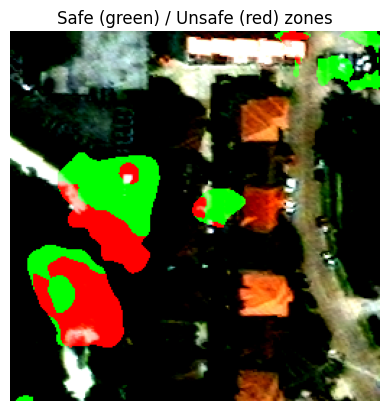

In [54]:
imgs, masks = next(iter(val_loader))
imgs, masks = imgs.to(device), masks.to(device)
with torch.no_grad(), autocast(device_type="cuda"):
    preds = model(imgs)
pred_map = torch.argmax(preds, dim=1)[0].cpu().numpy()

safe_mask   = (pred_map == 1)       # no-damage
unsafe_mask = (pred_map > 1)        # minor/major/destroyed

img_np = imgs[1].permute(1,2,0).cpu().numpy()
overlay = img_np.copy()
overlay[safe_mask] = [0,255,0]
overlay[unsafe_mask] = [255,0,0]

plt.imshow(0.6*img_np + 0.4*overlay)
plt.title("Safe (green) / Unsafe (red) zones")
plt.axis("off")
plt.show()

In [23]:
test_root = "test"
test_dataset = XBDDataset(test_root, patch_size=256, overlap=64, transform=val_transforms, load_patches=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False,
                         num_workers=2, pin_memory=True, persistent_workers=False)

model.load_state_dict(torch.load(save_path))
model.eval()

test_metrics = validate_efficient(model, test_loader, weights, num_classes=NUM_CLASSES)
print("\n Test-set results:")
print(f"Loss={test_metrics['val_loss']:.4f} | Weighted F1={test_metrics['weighted_f1']:.4f}")

# After test_metrics is computed
names = ["No Damage", "Minor", "Major", "Destroyed"]

for i, name in enumerate(names):
    cls_idx = i + 1      # shift 1→NoDamage, 2→Minor, 3→Major, 4→Destroyed
    print(f"{name:<12} F1={test_metrics['f1_per_class'][cls_idx]:.4f}  "
          f"Prec={test_metrics['precision'][cls_idx]:.4f}  "
          f"Rec={test_metrics['recall'][cls_idx]:.4f}  "
          f"IoU={test_metrics['iou_per_class'][cls_idx]:.4f}")

 Creating patch index from: test


100%|██████████| 933/933 [00:24<00:00, 37.73it/s]


Total patches indexed: 23325



 Test-set results:
Loss=0.8055 | Weighted F1=0.9484
No Damage    F1=0.6149  Prec=0.5488  Rec=0.6991  IoU=0.4439
Minor        F1=0.1951  Prec=0.1379  Rec=0.3330  IoU=0.1081
Major        F1=0.1768  Prec=0.1991  Rec=0.1590  IoU=0.0970
Destroyed    F1=0.4582  Prec=0.4539  Rec=0.4625  IoU=0.2972
